In [1]:
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.anchored_artists import (AnchoredSizeBar)
import matplotlib.font_manager as fm
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LogNorm
from astropy.visualization import ImageNormalize, LogStretch, AsinhStretch
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
import glob 
import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
f702_dir = '/Users/orion/phd_research/CSS2/overlays/1203_f702w/'
hst_dir = '/Users/orion/phd_research/CSS2/hst_data/cropped_drc/'
radio_dir = '/Users/orion/phd_research/CSS2/radio/'

In [3]:
rfile = get_pkg_data_filename(radio_dir+'1203+645_5GHz.fits')
hdu = fits.open(rfile)
d_init = hdu[0].data
h = hdu[0].header
hdu_r = d_init[0]
d = hdu_r[0].data

In [4]:
op = get_pkg_data_filename(hst_dir+'1203+645_f763m_shifted.fits')
hdu_op = fits.open(op)[0]

uv = get_pkg_data_filename(hst_dir+'1203+645_f336w_crayerased.fits')
hdu_uv = fits.open(uv)[0]

In [5]:
f702i = get_pkg_data_filename(f702_dir+'u27lek01p_c0m_shifted.fits')

hdu_f702i = fits.open(f702i)[1]   
#this image has 4 dimensions, 1203 is in [1]

In [6]:
def radio_contours(rms_sigma):
    
    lp= []
    for i in range(0,10):
        lp.append(2**i*rms_sigma)

    ln= []
    for i in range(0,2):
        ln.append(-2**i*rms_sigma)
        ln.sort()
    
    return lp,ln  

In [7]:
def find_optimal_wcs():

    #computing optimal WCS for 3 images -- 1203_f763, 1203_f336, 1203_f702
    
    list_hdus = [hdu_op, hdu_uv, hdu_f702i]
    wcs_out, shape_out = find_optimal_celestial_wcs(list_hdus)

    return wcs_out, shape_out


In [8]:
new_wcs, new_shape = find_optimal_wcs()

In [9]:
#hst 
new_hdu_op, reprojected_op_footprint = reproject_interp(hdu_op, new_wcs, new_shape)
new_hdu_op = gaussian_filter(new_hdu_op, 0.5)
new_hdu_uv, reprojected_uv_footprint = reproject_interp(hdu_uv, new_wcs, new_shape)
new_hdu_uv = gaussian_filter(new_hdu_uv, 1.5)

new_hdu_f702i, reprojected_f702i_footprint = reproject_interp(hdu_f702i, new_wcs, new_shape)
new_hdu_f702i = gaussian_filter(new_hdu_f702i, 0.5)


In [10]:
def fix():
    new_hdu_f702i[new_hdu_f702i<0.8] = np.nan
    

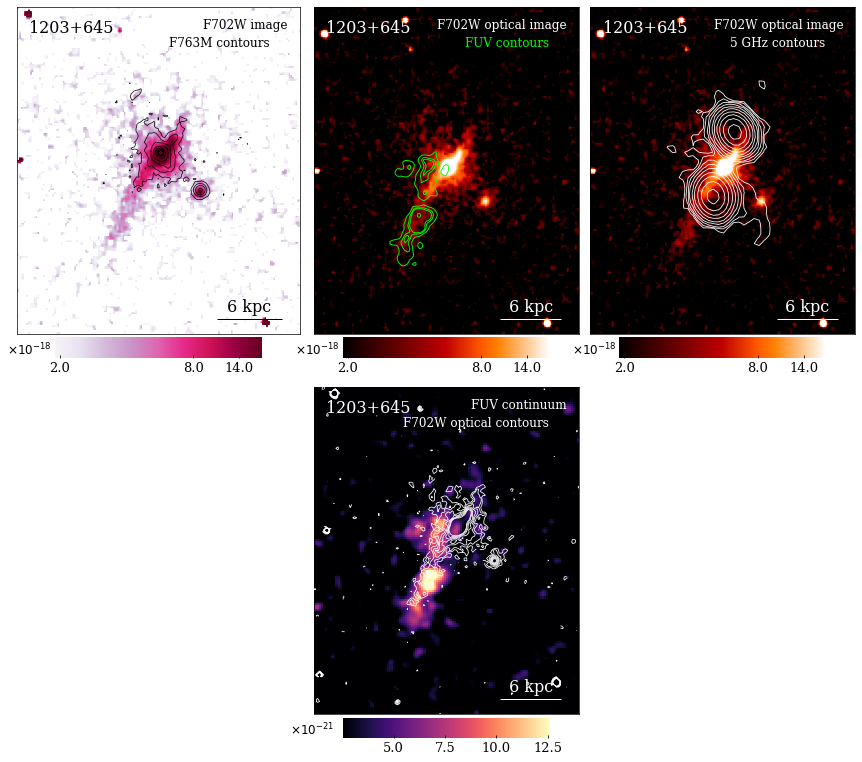

In [11]:

plt.rcParams['axes.linewidth'] = 0.7
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16,6))

#dimensions [left, bottom, width, height] in fractions of figure width and height
ax = fig.add_axes([0.05, 0.05, 0.3, 0.9], projection=new_wcs)
ax2 = fig.add_axes([0.30, 0.05, 0.3, 0.9], projection=new_wcs)
ax3 = fig.add_axes([0.54, 0.05, 0.3, 0.9], projection=new_wcs)
ax4 = fig.add_axes([0.30, -0.83, 0.3, 0.9], projection=new_wcs)


for axis in fig.get_axes():
    
    axis.tick_params(axis='both', color='k',direction='in', length=0)
    #axis.axis('off')
    lon = axis.coords[0]
    lat = axis.coords[1]
    lon.set_ticklabel_visible(False)
    lat.set_ticklabel_visible(False)


photflam_702 = 1.87e-18
factor = photflam_702/1e-18

norm1 = ImageNormalize(stretch=AsinhStretch(), vmin=1.0*factor, vmax=10.0*factor) 


im2 = ax2.imshow(new_hdu_f702i*factor, origin='lower', norm=norm1, cmap='gist_heat')
ax2.contour(new_hdu_uv, transform=ax2.get_transform(new_wcs),
           levels=[0.005,0.007,0.008,0.012,0.042,0.06], colors='lime', alpha=1.0, linewidths=0.9)

ax2.set_xlim(455, 585)
ax2.set_ylim(410, 570)


bar1 = AnchoredSizeBar(transform=ax2.transData, size=30, size_vertical=0.1,
                loc='lower right', pad=0.1, borderpad=1.0, sep= -20,
                color='white', label='6 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
ax2.add_artist(bar1)

Afont2 = {'family': 'serif', 'color': 'white','weight': 'normal','size': 16}
at1 = AnchoredText('1203+645',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont2, frameon=False)
at2 = AnchoredText('F702W optical image',loc='upper right', pad=0.5, prop=dict(color='white'),frameon=False)                                                   
at3 = AnchoredText('FUV contours',loc='upper right', pad=2.0, prop=dict(color='lime'), frameon=False)
ax2.add_artist(at1)
ax2.add_artist(at2)
ax2.add_artist(at3)

cbar2 = fig.colorbar(im2, ax=ax2, pad = 0.01, aspect=10, format= "%.1f", location='bottom', shrink=0.6) 
cbar2.ax.tick_params(direction='in', labelsize=13)
cbar2.ax.set_ylabel(r'$\times 10^{-18}$', labelpad=25, y=0.0, rotation=0)
cbar2.outline.set_visible(False)
cbar2.ax.locator_params(nbins=4)



rms = 0.3e-3
lp,ln = radio_contours(3*rms)
im3 = ax3.imshow(new_hdu_f702i*factor, origin='lower', norm=norm1, cmap='gist_heat')
ax3.contour(d, transform=ax3.get_transform(WCS(h,naxis=2)),
           levels=lp, colors='white', alpha=1.0, linewidths=0.8)

ax3.set_xlim(455, 585)
ax3.set_ylim(410, 570)

bar2 = AnchoredSizeBar(transform=ax3.transData, size=30, size_vertical=0.1,
                loc='lower right', pad=0.1, borderpad=1.0, sep= -20,
                color='white', label='6 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
ax3.add_artist(bar2)

Afont2 = {'family': 'serif', 'color': 'white','weight': 'normal','size': 16}
at4 = AnchoredText('1203+645',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont2, frameon=False)
at5 = AnchoredText('F702W optical image',loc='upper right', pad=0.5, prop=dict(color='white'),frameon=False)  
#prop gives error without "dict", reading textsize from rcParams
                                                 
at6 = AnchoredText('5 GHz contours',loc='upper right', pad=2.0, prop=dict(color='white'), frameon=False)
ax3.add_artist(at4)
ax3.add_artist(at5)
ax3.add_artist(at6)

cbar3 = fig.colorbar(im3, ax=ax3, pad = 0.01, aspect=10, format= "%.1f", location='bottom', shrink=0.6) 
cbar3.ax.tick_params(direction='in', labelsize=13)
cbar3.ax.set_ylabel(r'$\times 10^{-18}$', labelpad=25, y=0.0, rotation=0)
cbar3.outline.set_visible(False)
cbar3.ax.locator_params(nbins=4)




###############
#run in last iteration:

fix()

###############


im = ax.imshow(new_hdu_f702i*factor, origin='lower', norm=norm1, cmap='PuRd')
ax.contour(new_hdu_op, transform=ax.get_transform(new_wcs),
           levels=[0.015,0.03,0.05,0.11,0.26,0.47,0.6,0.7], colors='k', alpha=1.0, linewidths=0.7)

ax.set_xlim(455, 585)
ax.set_ylim(410, 560)

bar6 = AnchoredSizeBar(transform=ax.transData, size=30, size_vertical=0.1,
                loc='lower right', pad=0.1, borderpad=1.0, sep= -20,
                color='k', label='6 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
ax.add_artist(bar6)

Afont3 = {'family': 'serif', 'color': 'k','weight': 'normal','size': 16}
at7 = AnchoredText('1203+645',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont3, frameon=False)
at8 = AnchoredText('F702W image',loc='upper right', pad=0.5, frameon=False)  #prop gives error, 
                                                                                #reads size from rcParams
at9 = AnchoredText('F763M contours',loc='upper right', pad=2.0, frameon=False)
ax.add_artist(at7)
ax.add_artist(at8)
ax.add_artist(at9)

cbar = fig.colorbar(im, ax=ax, pad = 0.01, aspect=10, format= "%.1f", location='bottom', shrink=0.6) 
cbar.ax.tick_params(direction='in', labelsize=13)
cbar.ax.set_ylabel(r'$\times 10^{-18}$', labelpad=25, y=0.0, rotation=0)
cbar.outline.set_visible(False)
cbar.ax.locator_params(nbins=4)



photflam = 1.26e-18
factor = photflam/1e-21
im4 = ax4.imshow(new_hdu_uv*factor, origin='lower', vmin=0.002*factor, vmax=0.01*factor, 
                 cmap='magma', interpolation='none')

#new_hdu_f702i = gaussian_filter(new_hdu_f702i, 0.5)
ax4.contour(new_hdu_f702i, transform=ax4.get_transform(new_wcs),levels=[1.8,2.5,3.5,4.5,5.5,6.5,7.5], 
            colors='white', alpha=1.0, linewidths=0.8)

ax4.set_xlim(450, 580)
ax4.set_ylim(400, 560)

bar5 = AnchoredSizeBar(transform=ax4.transData, size=30, size_vertical=0.1,
                loc='lower right', pad=0.1, borderpad=1.0, sep= -20,
                color='white', label='6 kpc', frameon=False, fontproperties=fm.FontProperties(size=16))
ax4.add_artist(bar5)

Afont2 = {'family': 'serif', 'color': 'white','weight': 'normal','size': 16}
at10 = AnchoredText('1203+645',loc='upper left', pad=0.5, borderpad=0.3, prop=Afont2, frameon=False)
at11 = AnchoredText('FUV continuum',loc='upper right', pad=0.5, prop=dict(color='white'),frameon=False)  
at12 = AnchoredText('F702W optical contours',loc='upper right', pad=2.0, prop=dict(color='white'), frameon=False)
ax4.add_artist(at10)
ax4.add_artist(at11)
ax4.add_artist(at12)

cbar4 = fig.colorbar(im4, ax=ax4, pad = 0.01, aspect=10, format= "%.1f", location='bottom', shrink=0.6) 
cbar4.ax.tick_params(direction='in', labelsize=13)
cbar4.ax.set_ylabel(r'$\times 10^{-21}$', labelpad=30, y=0.0, rotation=0) 
#cbar4.ax.set_title(r'x10$^{-22}$', color='b')
cbar4.outline.set_visible(False)



plt.savefig('1203+645.pdf',facecolor='w', dpi=1000, bbox_inches='tight', pad_inches=0.5)
